In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')

# Explorative Data Analysis 

## Read Data

In [2]:
data = pd.read_csv("HY_Universe_corporate bond.csv")
print("There are", data.shape[0], "observations and", data.shape[1], "features in this dataset.")
print("From a rule of thumb, the sample complexity (#observations / #features) is about", round(data.shape[0]/data.shape[1]), 
      "which is greater than 20. Sample size is enough and we could try to use as many features as possible.")

There are 2721 observations and 37 features in this dataset.
From a rule of thumb, the sample complexity (#observations / #features) is about 74 which is greater than 20. Sample size is enough and we could try to use as many features as possible.


## Feature Description
- `CUSIP`: unique id of bond.
- `Ticker`: unknown categorical data with large size.
- `Issue Date` / `Maturity`: the date when bonds were made (pay off).
- `1st Call Date`: the earliest date issuer could pay off the bond.
- `Moodys`/`S&P`/`Fitch`/`Bloomberg`: rating of bond (categorical). Apply ordinal encoding
- `Coupon`: discrete (continuous?). There are mistakes of scale(unit).
- `Issued Amount`
- `Maturity Type`: Categorical data with samll size. Should check the consistency with 1st Call Date. Apply one-hot encoding.
- `Coupon Type`: Categorical data with samll size.
- `Maturity At Issue months`: a continuous feature refers to the length of time until a bond reaches maturity. 
- `Industry`: company's industry. Apply one-hot encoding.
- `LiquidityScore`: a continuous feature measures how easily the bond can be bought or sold in the market
- `Months in JNK`: number of months that particular bond is in JNK etf pool.
- `Months in HYG`: number of months that particular bond is in HYG etf pool.
- `Months in Both`: should check the consistency with previous two features.
- `IN_ETF`: whether the bond has been in etf pool. Should check the consistency with previous three features.
- `LIQ SCORE`: liquidity score, the same as LiquidityScore. (at different scale, check the consystency and could drop one).
- `n_trades`: number of trades during life time.
- `volume_trades`: total number of shares been traded.
- `total_median_size`/`total_mean_size`: the median/mean volume of a single trade.
- `n_days_trade`: the number of days that bond had trades. Propotional to liquidity score. Should check the consistency.
- `days_diff_max`: maximum interval where no trades happened.
- `percent_intra_dealer`: percent of trades that happened between two dealers, rather than between a dealer and an end investor.
- `percent_uncapped`: percentage of a bond's trading volume that is not subject to a predetermined maximum limit. A measure of liqudity.
- `bond_type`: categorical data with small size, apply one-hot encoding.
- `Client_Trade_Percentage`: unknow continuous features scale to [0, 1]. 
- `weekly_mean_volume`/`weekly_median_volume`/`weekly_max_volume`/`weekly_min_volume`/`weekly_mean_ntrades`/`weekly_median_ntrades`: are measures of volume and trades in week level.

## 

## Check the Correctness of Data

### Maturity Type and 1st Call Date
Callable bond could have 1st call date, other tpyes do not.

In [3]:
print("Bond types are as follows: ", data['Maturity Type'].unique())

Bond types are as follows:  ['CALLABLE' 'AT MATURITY' 'CALL/SINK' 'PERP/CALL' 'CALL/EXT' 'EXTENDIBLE'
 'SINKABLE' 'SINK/EXT' 'PUTABLE' 'CALL/REF/SINK' 'NORMAL' 'CALL/PUT']


In [4]:
# Maturity Type and 1st Call Date are good. No non-callale bond have call date.
condition1 = data['Maturity Type'] != "CALLABLE"
condition2 = data["1st Call Date"] != "Nan"
data.loc[condition1 & condition2, 'Maturity Type'].unique()

array(['PERP/CALL', 'CALL/SINK', 'CALL/EXT'], dtype=object)

### LiquidityScore and LIQ SCORE

In [5]:
# LiquidityScore = LIQ SCORE * 100
print("Total difference of LiquidityScore and LIQ SCORE for", data.shape[0], "samples are:", 
      sum(np.abs(data["LiquidityScore"]/100 - data['LIQ SCORE'])))

# Thus, drop LiquidityScore
data = data.drop(columns = "LiquidityScore")

Total difference of LiquidityScore and LIQ SCORE for 2721 samples are: 6.706200022174591e-07


### LiquidityScore and percent_uncapped
Check the relation of `LIQ SCORE` and `percent_uncapped` to make sure my understand of `percent_uncapped` is correct. <br>
From the following plot, we can tell that `percent_uncapped` is an indicator positively correlated to liquidity.

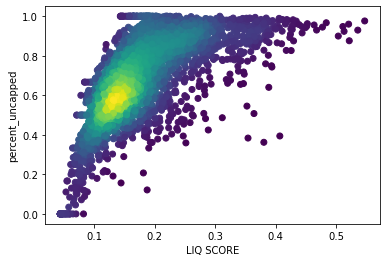

In [6]:
from scipy.stats import gaussian_kde
xy = np.vstack([data["LIQ SCORE"], data["percent_uncapped"]])
z = gaussian_kde(xy)(xy)
plt.scatter(data["LIQ SCORE"], data["percent_uncapped"], c=z)
plt.xlabel("LIQ SCORE")
plt.ylabel("percent_uncapped")
plt.show()

### ETF Related Features

1. `Months in Both` should be smaller than or equal to the minimum of `Months in JNK` and `Months in HYG`
2. `IN_ETF` is Yes if minimum of `Months in JNK` and `Months in HYG` > 0

In [7]:
# Convert Months in Both from string to integer
data.loc[data['Months in Both']=="Nan", "Months in Both"] = "0"
data.loc[data['Months in JNK']=="Nan", "Months in JNK"] = "0"
data.loc[data['Months in HYG']=="Nan", "Months in HYG"] = "0"
data["Months in Both"] = data["Months in Both"].astype(int)
data["Months in JNK"] = data["Months in JNK"].astype(int)
data["Months in HYG"] = data["Months in HYG"].astype(int)

# `Months in Both` should be smaller than or equal to the minimum of `Months in JNK` and `Months in HYG`
condition1 = data.loc[:, ["Months in JNK", "Months in HYG"]].min(axis = 1) >= data["Months in Both"]

# `IN_ETF` is Yes
condition2 = data["IN_ETF"] == "Yes"

# At lease in one of pool
condition3 = data.loc[:, ["Months in JNK", "Months in HYG"]].max(axis = 1) != 0


data.loc[~condition1, ["Months in JNK", "Months in HYG", "Months in Both"]]

,Months in JNK,Months in HYG,Months in Both


In [8]:
# Check whether condition2 and condition3 are not matched
data.loc[condition2 != condition3, ["Months in JNK", "Months in HYG", "IN_ETF"]]

,Months in JNK,Months in HYG,IN_ETF


From results above, ETF related features are consistent.

### Coupon

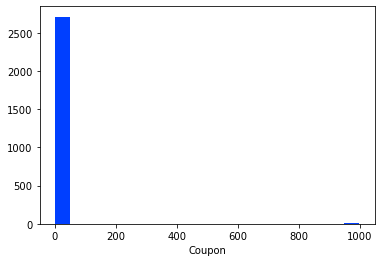

In [9]:
plt.hist(data["Coupon"], bins=20)
plt.xlabel("Coupon")
plt.show()

The distribution of coupon should not look like this. There are some extreme values.

In [10]:
data.loc[data['Coupon']>50, "Coupon"]

393     999.0
435     999.0
439     999.0
723     999.0
955     999.0
1022    999.0
1023    999.0
1061    999.0
1419    999.0
1547    999.0
2241    999.0
Name: Coupon, dtype: float64

We have no further information to fix the error and sample size is large enough. Thus, we choose to drop those observations.

In [11]:
data = data[data['Coupon']<50]

### Maturity and Maturity at Issue Month
There are some NaN values in maturity. First we check whether `Maturity At Issue months` matched with `Issue Date` and `Maturity`. If so, we could use two to compute and refill the NaN values.

In [12]:
print("There are", data["Maturity At Issue months"].isna().sum(), "NaN value in Maturity At Issue months.")

There are 0 NaN value in Maturity At Issue months.


In [13]:
# Maturity is a string type
print("There are", (data["Maturity"] == "Nan Field Not Applicable").sum(), "NaN values in Maturity")


There are 83 NaN values in Maturity


In [14]:
# Check match
date_data = data.loc[data["Maturity"] != "Nan Field Not Applicable", ["Issue Date", "Maturity", "Maturity At Issue months"]]
date_data

,Issue Date,Maturity,Maturity At Issue months
0,7/1/2014,7/1/2019,60.87
1,3/15/2004,6/4/2018,173.13
2,5/14/2010,3/15/2015,58.87
3,6/17/2013,4/30/2020,83.63
4,12/22/2016,12/15/2024,97.17
...,...,...,...
2716,4/18/2017,1/15/2027,118.63
2717,3/14/2007,12/15/2025,228.37
2718,7/25/2006,8/15/2016,122.47
2719,8/5/2014,8/15/2024,122.10


In [15]:
date_data["Issue Date"] = pd.to_datetime(date_data.loc[:, "Issue Date", ])
date_data["Maturity"] = pd.to_datetime(date_data.loc[:, "Maturity", ])

In [16]:
# (maturity date(days) - issue date(days)) / 30 (per month) - Maturity At Issue months, 
# then divided by Maturity At Issue months to compute the errors in percentage.
errors = np.abs((date_data["Maturity"] - date_data["Issue Date"])/np.timedelta64(1, 'M') -
                date_data["Maturity At Issue months"])/date_data["Maturity At Issue months"]

print("Maximum error is " + str(round(errors.max()*100,2))+"%.")

Maximum error is 1.46%.


Maximum error of prediction is 1. 46%, which is accurate, considering rounding of feature `Maturity At Issue months`. 

In [17]:
data["Issue Date"] = pd.to_datetime(data.loc[:, "Issue Date"])
# Observations where maturity is NaN
condition1 = data["Maturity"] == "Nan Field Not Applicable"

In [18]:
# Selection the observations and assign computed values
data.loc[condition1, "Maturity"] = \
(data.loc[condition1, "Issue Date"] + np.timedelta64(1, 'M') * data.loc[condition1, "Maturity At Issue months"]).dt.date
# Check computation is correct
data.loc[condition1, ["Issue Date", "Maturity", "Maturity At Issue months"]].head()

,Issue Date,Maturity,Maturity At Issue months
84,2000-02-07,2030-12-08,370.03
304,2014-11-10,2019-12-11,61.03
305,2015-03-02,2020-04-10,61.33
495,2016-06-15,2026-08-07,121.73
529,2007-02-16,2017-12-05,129.63


### General View of Issued Amount

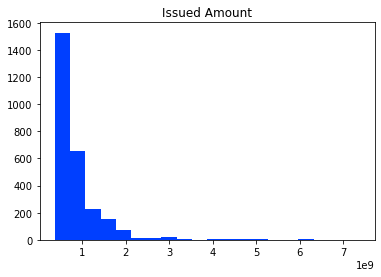

In [19]:
plt.hist(data["Issued Amount"], bins=20)
plt.title("Issued Amount")
plt.show()

### General View of difference of median and mean
From the plot, we could see that generally the distribtuion is not skew heavily since median and mean are close. However, there are rare cases when median is significantly smaller than mean. (Most of data are placed in right half of the axis)

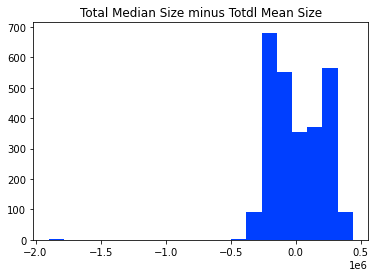

In [20]:
plt.hist(data['total_median_size'] - data['total_mean_size'], bins=20)
plt.title("Total Median Size minus Totdl Mean Size")
plt.show()

In [21]:
# Up to now, it seems harmless. Keep an eye on this observation. 
data[(data['total_median_size'] - data['total_mean_size']) < -1000000]

,CUSIP,Ticker,Issue Date,Maturity,1st Call Date,Moodys,S_and_P,Fitch,Bloomberg Composite Rating,Coupon,...,percent_intra_dealer,percent_uncapped,bond_type,Client_Trade_Percentage,weekly_mean_volume,weekly_median_volume,weekly_max_volume,weekly_min_volume,weekly_mean_ntrades,weekly_median_ntrades
2142,500630BQ0,KDB,2009-01-23,1/23/2014,Nan,WR,NR,NR,NR,8.0,...,0.4,0.6,5,0.4,5375000.0,5375000.0,5750000.0,5000000.0,2.5,1


### Check all percentage data are in range of (0, 1)

In [22]:
np.sum(
    (data.loc[:, ["percent_intra_dealer", "percent_uncapped", "Client_Trade_Percentage"]] > 1) | \
    (data.loc[:, ["percent_intra_dealer", "percent_uncapped", "Client_Trade_Percentage"]] < 0)
)
# All data fall in range

percent_intra_dealer       0
percent_uncapped           0
Client_Trade_Percentage    0
dtype: int64

## Visualization of Basic Features

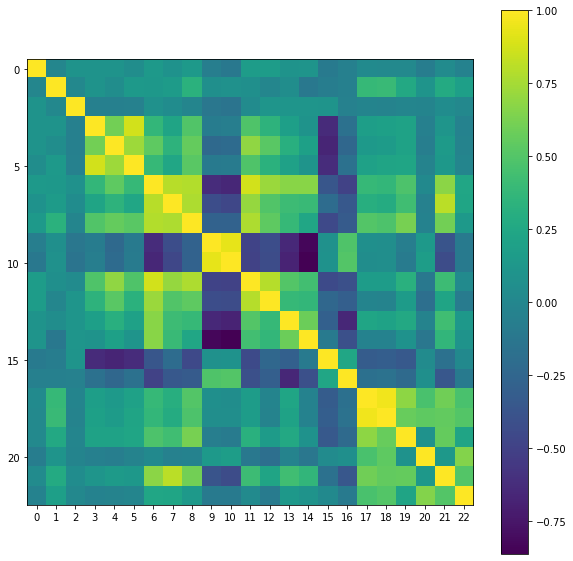

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
corr_matrix = data.loc[:, ['Coupon',  'Issued Amount',  'Maturity At Issue months', 'Months in JNK',
       'Months in HYG', 'Months in Both', 'LIQ SCORE', 'n_trades',
       'volume_trades', 'total_median_size', 'total_mean_size', 'n_days_trade',
       'days_diff_max', 'percent_intra_dealer', 'percent_uncapped',
       'bond_type', 'Client_Trade_Percentage', 'weekly_mean_volume',
       'weekly_median_volume', 'weekly_max_volume', 'weekly_min_volume',
       'weekly_mean_ntrades', 'weekly_median_ntrades']].corr()
img = ax.imshow(corr_matrix)
ax.set_xticks(np.arange(23))
plt.colorbar(img)
plt.draw()
plt.show()

1. last six features are positively correlated. Feature names are: 'weekly_mean_volume', 'weekly_median_volume', 'weekly_max_volume', 'weekly_min_volume', 'weekly_mean_ntrades', 'weekly_median_ntrades'. **They masure the volume and number of trades in week level.**
2. feature 3 to feature 5 are positively correlated. Feature names are: 'Months in JNK', 'Months in HYG', 'Months in Both'. **They are related to ETF.**
3. feature 6 to feature 8 are positively correlated. Feature names are: 'LIQ SCORE', 'n_trades', 'volume_trades. **They measure the liquidity of a bond.**
4. feature 11 to feature 14 are positively correlated. Feature names are: 'n_days_trade', 'days_diff_max', 'percent_intra_dealer', 'percent_uncapped'. **They describe how the bond are traded.**
5. feature group 9-10 is negatively correlated with group 11-14.

### Time Range
Want to see how old is this dataset. From the plots shown beblow, most of the bonds were issued from 2012 to 2016. 

In [24]:
date = pd.date_range(data["Issue Date"].min(), data["Issue Date"].max() - np.timedelta64(1, 'D'), freq='y')

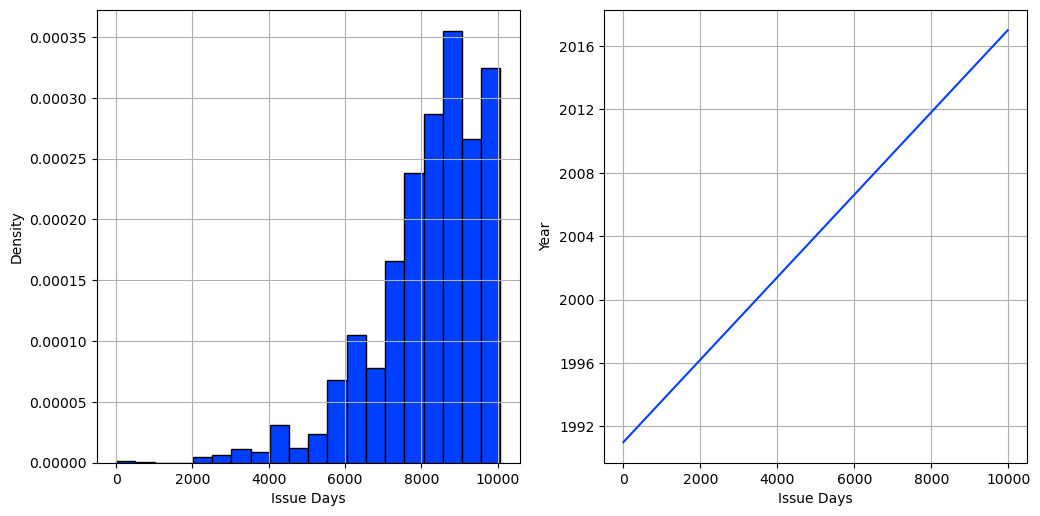

In [25]:
# Compute time difference with the earliest issue date.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=100)
ax[0].hist((data["Issue Date"] - data["Issue Date"].min()) / np.timedelta64(1, 'D'), density=True, edgecolor='black', bins=20)
ax[0].set_xlabel("Issue Days")
ax[0].set_ylabel("Density")
ax[0].grid()
ax[1].plot(list(range(0, 10000, int(10000/26))), list(date))
ax[1].set_ylabel("Year")
ax[1].set_xlabel("Issue Days")
ax[1].grid()
plt.show()

### Industries Distribtuion
There are 69 industries, most of them take only minor parts. From the following result, we could tell that Energy and Finance take about 30% of the market.

In [26]:
industry = data.groupby(["Industry"]).count()[["CUSIP"]]/data.shape[0]
industry.columns = ["Count"]
industry = industry.reset_index()

# Since other industies are too small, group them together
industry.loc[industry["Count"] < 0.05, "Industry"] = "Other"

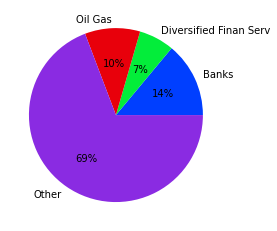

In [27]:
plt.pie(industry.groupby("Industry").sum()["Count"], labels=["Banks", "Diversified Finan Serv", "Oil Gas", "Other"], 
       autopct='%.0f%%')
plt.show()

### See how bond's tenor relate to liquidity score

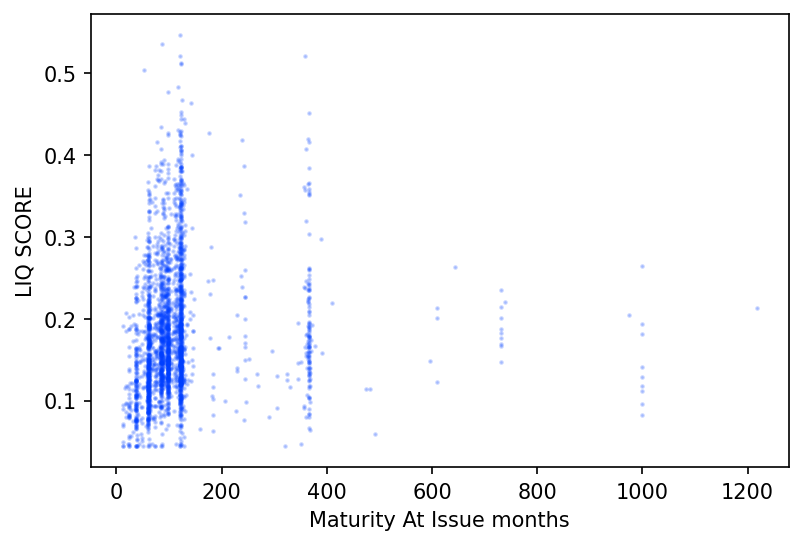

In [28]:
plt.figure(dpi=150)
plt.scatter(data["Maturity At Issue months"], data["LIQ SCORE"], alpha=0.2, s=1.5)
plt.xlabel("Maturity At Issue months")
plt.ylabel("LIQ SCORE")
plt.show()

From above plot, we can't see any patterns between Liquidity and tenor of the bonds. But, `Maturity At Issue months` has some customary lengths. (Straight lines formed by points) <br>
If we want to take a further look of the pair, we could groupby those length (we could treat them as categorical), and compare the mean.

### LiquidityScore and percent_uncapped
`LIQ SCORE` and `percent_uncapped` are largely linear dependent in [0.1, 0.3] range.

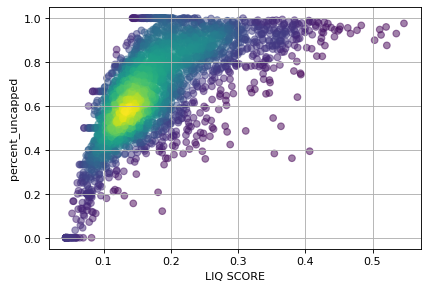

In [29]:
xy = np.vstack([data["LIQ SCORE"], data["percent_uncapped"]])
z = gaussian_kde(xy)(xy)
plt.figure(dpi=80)
plt.scatter(data["LIQ SCORE"], data["percent_uncapped"], c=z, alpha=0.5)
plt.grid()
plt.xlabel("LIQ SCORE")
plt.ylabel("percent_uncapped")
plt.show()

### In ETF

Mean and variance are larger for distribution of IN_ETF bond's `n_trades`. And bond's `volume_trades` has the same pattern.

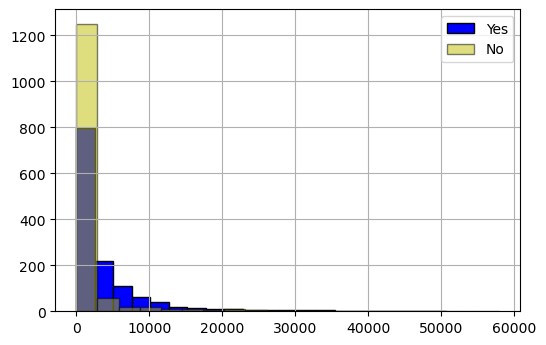

In [30]:
# cap at 5000 because there are  extremely large amount of trades for some single bond.
plt.figure(dpi=100)
plt.hist(data.loc[data["IN_ETF"]=="Yes", "n_trades"], alpha=1, label="Yes", bins=20, edgecolor='black', color="b")
plt.hist(data.loc[data["IN_ETF"]=="No", "n_trades"], alpha=0.5, label="No", bins=20, edgecolor='black', color="y")
plt.grid()
plt.legend(loc='upper right')
plt.show()

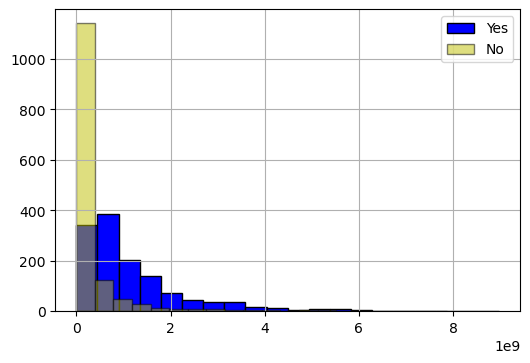

In [31]:
plt.figure(dpi=100)
plt.hist(data.loc[data["IN_ETF"]=="Yes", "volume_trades"], alpha=1, label="Yes", bins=20, edgecolor='black', color='b' )
plt.hist(data.loc[data["IN_ETF"]=="No", "volume_trades"], alpha=0.5, label="No", bins=20, edgecolor='black', color='y')
plt.grid()
plt.legend(loc='upper right')
plt.show()

### Coupon and Maturity Type
The coupon is higher for bonds where the issuer has more rights.

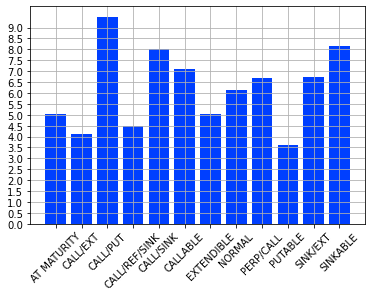

In [33]:
coupon_group = data.groupby(["Maturity Type"]).mean()[["Coupon"]]
plt.bar(list(coupon_group.index), coupon_group["Coupon"])
plt.xticks(rotation=45)
plt.yticks(np.linspace(0, 9, 19))
plt.grid()
plt.show()

### Reduce Dimensions and Group Data

In [34]:
# Select numeric data and see whether there are clusters.
# Then check those whether those clusters match with categoricald data

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.loc[:, ['Coupon',  'Issued Amount',  'Maturity At Issue months', 'Months in JNK',
       'Months in HYG', 'Months in Both', 'LIQ SCORE', 'n_trades',
       'volume_trades', 'total_median_size', 'total_mean_size', 'n_days_trade',
       'days_diff_max', 'percent_intra_dealer', 'percent_uncapped',
       'bond_type', 'Client_Trade_Percentage', 'weekly_mean_volume',
       'weekly_median_volume', 'weekly_max_volume', 'weekly_min_volume',
       'weekly_mean_ntrades', 'weekly_median_ntrades']])

# Perform PCA on the scaled data
pca = PCA()
pca_components = pca.fit_transform(scaled_data)

0.6234376736936977

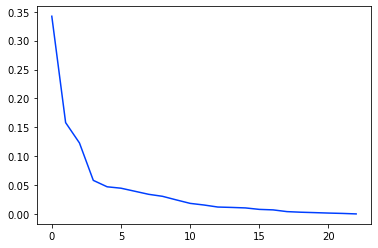

In [36]:
plt.plot(pca.explained_variance_ratio_)
pca.explained_variance_ratio_[0:3].sum()

The result of PCA is bad. Features may have more noise and randomness. Or features are relied on non-linear relationship.

### percent_intra_dealer (institution trade percent)
See what kinds of bond that dealers prefer.

#### ETF

In [45]:
# Bonds in ETF has 50% more dealers trade compared with not in ETF.
data.groupby(["IN_ETF"]).mean()[["percent_intra_dealer"]]

,percent_intra_dealer
IN_ETF,
No,0.199610
Yes,0.292224


#### Indsutries that dealers prefer

In [58]:
data.groupby(["Industry"]).mean()[["percent_intra_dealer"]].sort_values(by="percent_intra_dealer", ascending=False).head(10)

,percent_intra_dealer
Industry,
Savings Loans,0.513134
Textiles,0.489567
Holding Companies-Divers,0.430835
Miscellaneous Manufactur,0.398668
Energy-Alternate Sources,0.380457
Electronics,0.368899
Semiconductors,0.354855
Computers,0.354702
Auto Manufacturers,0.337239
